In [1]:
# Note: Make sure your dump file has sorted atom id
# make sure the z-position is in the 4th location

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

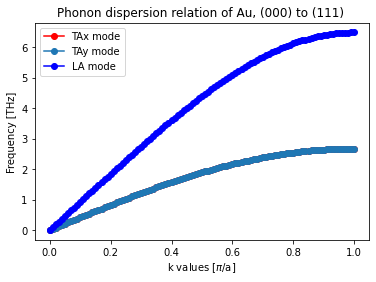

In [3]:
# Reading the phonon dispersion data:
filename = 'Au_morse.disp'
with open(filename, 'r') as file:
    lines = file.readlines()

data = [line.split() for line in lines if not line.startswith('#')]

data = np.array(data)
data = data.astype(np.float64)
cm_2_THz = 29979245800/1e12
TAx = data[0::3][:, 1]*cm_2_THz  # in (cm-1)
TAy = data[1::3][:, 1]*cm_2_THz  # in (cm-1)
LA = data[2::3][:, 1]*cm_2_THz   # in (cm-1)
k_val = (data[0::3][:, 0] - 1)/100

plt.plot(k_val, TAx, 'o-r', label='TAx mode')
plt.plot(k_val, TAy, 'o-', label='TAy mode')
plt.plot(k_val, LA, 'o-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.legend()
plt.show()

In [4]:
os.system('ls')

Au_111_18x10x332_Au_24_C32_6x5_A002_k2_vel.lmp
Au_111_18x10x332_Au_24_C32_6x5_A002_k4_novel.lmp
Au_111_orig_z.dat
Au_MNL_relax_105547_A02_k4_randvel.lmp
Au_MNL_relax_105547_A1_k4_randvel.lmp
Au_MNL_relax_105547_A1_k4_zerovel.lmp
Au_MNL_relax_105547_k4_novel.lmp
Au_MNL_relax_105547_k4_randvel.lmp
Au_MNL_relax_366420_k4_novel.lmp
Au_MNL_relax_368656_A02_k05_vel.lmp
Au_MNL_relax_368656_A02_k06_vel.lmp
Au_MNL_relax_368656_A02_k1_randvel.lmp
Au_MNL_relax_368656_A02_k1_vel.lmp
Au_MNL_relax_368656_A02_k4_randvel.lmp
Au_morse.disp
data_cg_boxrelax2.Au_MNL_relax_105547.lmp
data_cg_boxrelax.Au_MNL_relax_355147.lmp
data_cg_boxrelax.Au_MNL_relax_363117
data_cg_boxrelax.Au_MNL_relax_366420.lmp
data_fire.Au_MNL_relax_368656.lmp
Disp_plot.ipynb
dumps-1_NVE.lmc
Phonon_wave_propagation.ipynb
Phonon_wave_t0.ipynb
Phonon_wave_t0_velcorr.ipynb
Wave-packet_disp5ps.png
Wave-packet_vel5ps.png
z_disp_vel.dat


0

In [5]:
# Input variables:

# Structural variable:
relaxed_str = "data_fire.Au_MNL_relax_368656.lmp"
dump_file = "dumps-1_NVE.lmc"
dump_z_pos = 4    # x = 2, y=3, z= 4 for LAMMPs produced

Lz = 2528.84      # Length of box in Z-direction in Angstrom, required to correct PBC
N_atoms = 384000  # Number of atoms
N_layeratom = 360 # Number of atoms in each Au(111) layer N_atoms/N_layer
offset_p = 38     #19
add_Au = 996      # Added Au layers
orig_Au = 24      # Existing Au layers
N_plane = add_Au+orig_Au

# Phonon variables:
a0 = 4.079016               # lattice parameter of Au, a = 4.0782(lit), 4.07901835(calc)
A = 0.02                   # Amplitude of the wave in angstrom, 2e-3
eps_k0 = 1                  # e(k0) = Polarization wave vector, why 1?
val = 5                     # 5=0.05, 10 = 0.1, 20 =0.2, 30 = 0.3, 40 = 0.4 
# a = a0                    # Case-1     
# a = a0*np.sqrt(3)         # Case-2
a = a0/np.sqrt(3)           # Case-3
gamma = 50*a0               # Spatial extent

In [6]:
# Now take the original structure after Energy minimization and instill the phonon wave-packet
with open(relaxed_str, "r") as file:   # jid=253256
    lines = file.readlines()
    total_lines = len(lines)
    print('Total lines:', total_lines)

# Read position data:
plines = lines[offset_p:(N_atoms+offset_p)]
# Extract data from line 38 to 384038
position = np.array([list(map(float, line.strip().split())) for line in plines])
print("Shape of position:", position.shape)

# Sorting the Z-position according to atom id:
sorted_index = np.argsort(position[:, 0])
Original_position = position[sorted_index]      # col 4 = x, col 5 = y, col 6 = z


# Read velocity data:
offset_v = N_atoms+offset_p + 3
vlines = lines[offset_v:(N_atoms+offset_v)]
# Extract data from line 19 to 358579
velocity = np.array([list(map(float, line.strip().split())) for line in vlines])
print("Shape of velocity:", velocity.shape)


Total lines: 791090
Shape of position: (384000, 10)
Shape of velocity: (384000, 4)


In [7]:
dplane = a0/np.sqrt(3)                  # Distance between Au(111) planes
Au_bottom = np.min(position[:, 6])      # Bottom layer of Au     
Au_top = Au_bottom + dplane*N_plane - 1 # Top layer of Au
print('Top layer of Au:', Au_top)
# Selecting position within Au_bottom and Au_top:
Au_111_layers = position[position[:, 6] < Au_top]
MNL_layers = position[position[:, 6] > Au_top]

Top layer of Au: 2400.59590689795


In [8]:
# initialize the new array
Au_layers = np.zeros((N_plane, 1)) # Creating empty array

# loop over the number of averages
for i in range(N_plane):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows
    avg = np.mean(Au_111_layers[start:end, 6], axis=0)
    
    # store the average in the new array
    Au_layers[i, 0] = avg

Au_layers = Au_layers.reshape(-1)  

# Computing the displacements
xn = Au_layers                             # All positions


In [9]:
with open(dump_file, "r") as file:
    lines = file.readlines()
    print(len(lines))

8064189


In [10]:
Total_lines = len(lines)                    # Total no. of lines
Total_frames = Total_lines//(N_atoms + 9)    # Count all the frames

In [11]:
Z_pos = np.zeros((N_atoms, Total_frames)) # 358560 X 14(frames)
vel_mag = np.zeros((N_atoms, Total_frames)) 
offset_p = 9

for i in np.arange(Total_frames):
    # Read position data:
    a = int(N_atoms*i + offset_p*(i+1))
    b = int((N_atoms + offset_p)*(i+1))
    plines = lines[a:b]

    dump_pos = np.array([list(map(float, line.strip().split())) for line in plines])
#     print("Shape of position:", dump_pos.shape)
    Z_pos[:, i] = dump_pos[:, dump_z_pos]
    
#     vel_mag[:, i] = np.sqrt(dump_pos[:, 5]**2 + dump_pos[:, 6]**2+ dump_pos[:, 7]**2)
    vel_mag[:, i] = dump_pos[:, 7]
    
# Z_pos has data in following way
# data saved every 15000 steps, dt=0.0005 ps, so frames every 7.5 ps
# t=0, t=7.5 ps, t=15 ps ...
# these Z-positions are ordered according to atom id

In [12]:
# Calculating the difference between new atomic position and Original Z-position
diff = Z_pos - Original_position[:, 6][:, None] @ np.ones(Total_frames)[None, :]

In [13]:
# This array have data in following order
# atom id (arranged) [Z-position Differences a/c to atom id]  
new_arr = np.hstack((Original_position[:, 0][:, None], Original_position[:, 6][:, None], diff))

# Now lets sort this array according to 2nd column, i.e, the Z-position
sort_index = np.argsort(new_arr[:, 1])
new_arr = new_arr[sort_index]        # col 1 = atom id, col 2 = sorted Z-position, col 3: = Z-pos diff

#Creating vel_arr to sort as Z-position:
vel_arr = np.hstack((Original_position[:, 0][:, None], Original_position[:, 6][:, None], vel_mag))
sort_index = np.argsort(vel_arr[:, 1])
vel_arr = vel_arr[sort_index]

In [14]:
# Fixing the issue due periodic boundary condition:
# This issue arises when atoms at the boundary move during the simulation
# So, the total box-length should be added or subtracted based on atom position
# new_arr[:, 2:] = np.where(new_arr[:, 2:] < -100,  Lz + new_arr[:, 2:], new_arr[:, 2:])
# new_arr[:, 2:] = np.where(new_arr[:, 2:] >  100,  Lz - new_arr[:, 2:], new_arr[:, 2:])

In [15]:
# new_arr contains atomid Z-pos diff, this with increasing Z-pos
Au_111_diff = new_arr[0:Au_111_layers.shape[0], :]
MNL_layer_diff = new_arr[Au_111_layers.shape[0]:, 2:]

In [16]:
# Now lets average the atoms in each layers

# initialize the new array
phonon_wave = np.zeros((N_plane, Total_frames)) # Creating empty array
vel_wave = np.zeros((N_plane, Total_frames))

# loop over the number of averages
for i in range(N_plane):
    start = i * N_layeratom
    end = (i + 1) * N_layeratom
    
    # calculate the average of every 360 rows for position
    avg = np.mean(Au_111_diff[:, 2:][start:end, :], axis=0)
    vel_avg = np.mean(vel_arr[:, 2:][start:end, :], axis=0)
    
    # store the average in the new array
    phonon_wave[i, :] = avg          # purely contains differences in displacement only.
    vel_wave[i, :] = vel_avg

In [17]:
# np.savetxt("PW_simulation_347370.dat", phonon_wave)
# np.savetxt("Z-positions.dat", xn)

(1020, 21)


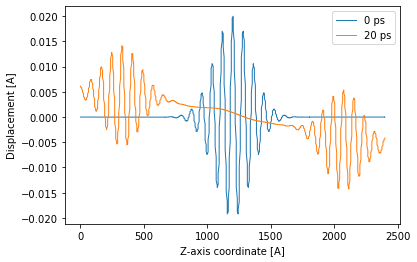

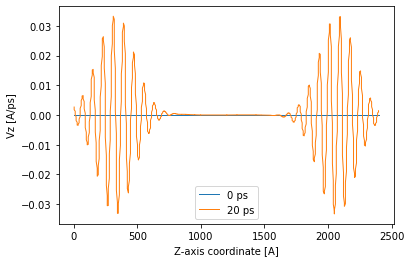

In [19]:
print(phonon_wave.shape)
frame=20
label_value = f'{frame} ps'
fig_disp = f'Wave-packet_disp{frame}ps.png'
fig_vel = f'Wave-packet_vel{frame}ps.png'

# Plot the position
plt.plot(xn, phonon_wave[:, 0], '-', linewidth=1,label='0 ps')
plt.plot(xn, phonon_wave[:, frame], '-', linewidth=1, label=label_value)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
# plt.xlim(500, 550)
# plt.ylim(-0.003, 0.003)
plt.legend()
plt.savefig(fig_disp, dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()


# Plot the velocity
plt.plot(xn, vel_wave[:, 0], '-', linewidth=1,label='0 ps')
plt.plot(xn, vel_wave[:, frame], '-', linewidth=1, label=label_value)
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Vz [A/ps]")
plt.legend()
plt.savefig(fig_vel, dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()